This notebook uses `numpyro` and replicates experiments in references [1] and [2] which evaluates the performance of HMC/NUTS on various frameworks.

In [1]:
%matplotlib inline

import time

import matplotlib.pyplot as plt
import numpy as onp
from sklearn.datasets import fetch_covtype

import jax.numpy as np
from jax import jit, lax, random

import numpyro.distributions as dist
from numpyro.distributions.util import validation_disabled
from numpyro.handlers import sample
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import hmc_kernel
from numpyro.util import tscan_nonprim, control_flow_prims_disabled

/home/fehiepsi/miniconda3/envs/pydata/lib/python3.6/site-packages/jax/lib/xla_bridge.py:144: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


We do preprocessing steps as in [source code](https://github.com/google-research/google-research/blob/master/simple_probabilistic_programming/no_u_turn_sampler/logistic_regression.py) of reference [2].

In [2]:
data = fetch_covtype()
features = data.data
labels = data.target

# normalize features and add intercept
features = (features - features.mean(0)) / features.std(0)
features = np.hstack([features, np.ones((features.shape[0], 1))])

# make binary feature
_, counts = onp.unique(labels, return_counts=True)
specific_category = np.argmax(counts)
labels = (labels == specific_category)

N, dim = features.shape
print("Data shape:", features.shape)
print("Label distribution: {} has label 1, {} has label 0".format(labels.sum(), N - labels.sum()))

Data shape: (581012, 55)
Label distribution: 211840 has label 1, 369172 has label 0


Construct model

In [3]:
def model(data, labels):
    coefs = sample('coefs', dist.norm(np.zeros(dim), np.ones(dim)))
    logits = np.dot(data, coefs)
    return sample('obs', dist.bernoulli(logits, is_logits=True), obs=labels)

### Benchmark HMC against Edward

In [4]:
num_steps, num_samples = 10, 100
step_size = np.sqrt(0.5 / N)
init_params = {"coefs": np.zeros(dim)}

In [5]:
with validation_disabled():
    start = time.time()
    _, potential_fn = initialize_model(random.PRNGKey(1), model, (features, labels,), {})

    start = time.time()
    init_kernel, sample_kernel = hmc_kernel(potential_fn, algo="HMC")
    hmc_state, _, _ = init_kernel(init_params, num_warmup_steps=0, step_size=step_size,
                                  num_steps=num_steps, run_warmup=False)

    start = time.time()
    hmc_state = hmc_state.update(step_size=1.)  # HACK: force fast compiling!
    jsample_kernel = jit(sample_kernel)
    jsample_kernel(hmc_state)
    setup_time = time.time() - start
    print("time to compile sample_kernel:", setup_time)

time to compile sample_kernel: 5.403517484664917


In [6]:
hmc_state = hmc_state.update(step_size=step_size)
start = time.time()
hmc_states = tscan_nonprim(lambda state, i: jsample_kernel(state), hmc_state, np.arange(num_samples),
                           transform=lambda state: {"coefs": state.z["coefs"],
                                                    "num_steps": state.num_steps})
sampling_time = time.time() - start
num_leapfrogs = np.sum(hmc_states["num_steps"]).copy()
print("time to get 100 samples :", sampling_time)
print("number of leapfrog steps:", num_leapfrogs)
print("avg. time for each step :", sampling_time / num_leapfrogs)

time to get 100 samples : 43.94540596008301
number of leapfrog steps: 1000
avg. time for each step : 0.043945405960083006


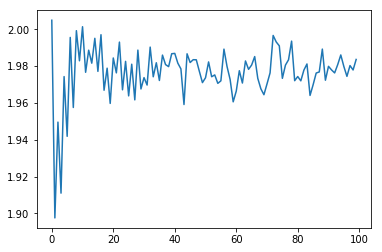

In [7]:
plt.plot(hmc_states["coefs"][:, 0]);

In [8]:
import tensorflow as tf
import edward as ed

print("tensorflow version:", tf.__version__)
print("edward version:", ed.__version__)

ed.set_seed(0)
coefs = ed.models.Normal(loc=tf.zeros(dim), scale=tf.ones(dim))
logits = tf.tensordot(features.copy(), coefs, [[1], [0]])
y = ed.models.BernoulliWithSigmoidProbs(logits)

qcoefs = ed.models.Empirical(params=tf.Variable(tf.zeros([num_samples, dim])))
inference = ed.HMC({coefs: qcoefs}, data={y: labels.copy().astype(np.float32)})
%time inference.run(step_size=step_size.copy(), n_steps=num_steps)

tensorflow version: 1.6.0
edward version: 1.3.5


/home/fehiepsi/miniconda3/envs/pydata/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


100/100 [100%] ██████████████████████████████ Elapsed: 53s | Acceptance Rate: 0.980
CPU times: user 1min 31s, sys: 1min 10s, total: 2min 42s
Wall time: 53.4 s


### Benchmark NUTS against Edward 2

In [9]:
num_samples = 10
step_size = 0.00167132
init_params = {"coefs": np.array(
    [+2.03420663e+00, -3.53567265e-02, -1.49223924e-01, -3.07049364e-01,
     -1.00028366e-01, -1.46827862e-01, -1.64167881e-01, -4.20344204e-01,
     +9.47479829e-02, -1.12681836e-02, +2.64442056e-01, -1.22087866e-01,
     -6.00568838e-02, -3.79419506e-01, -1.06668741e-01, -2.97053963e-01,
     -2.05253899e-01, -4.69537191e-02, -2.78072730e-02, -1.43250525e-01,
     -6.77954629e-02, -4.34899796e-03, +5.90927452e-02, +7.23133609e-02,
     +1.38526391e-02, -1.24497898e-01, -1.50733739e-02, -2.68872194e-02,
     -1.80925727e-02, +3.47936489e-02, +4.03552800e-02, -9.98773426e-03,
     +6.20188080e-02, +1.15002751e-01, +1.32145107e-01, +2.69109547e-01,
     +2.45785132e-01, +1.19035013e-01, -2.59744357e-02, +9.94279515e-04,
     +3.39266285e-02, -1.44057125e-02, -6.95222765e-02, -7.52013028e-02,
     +1.21171586e-01, +2.29205526e-02, +1.47308692e-01, -8.34354162e-02,
     -9.34122875e-02, -2.97472421e-02, -3.03937674e-01, -1.70958012e-01,
     -1.59496680e-01, -1.88516974e-01, -1.20889175e+00])}

In [10]:
with validation_disabled():
    start = time.time()
    _, potential_fn = initialize_model(random.PRNGKey(1), model, (features, labels,), {})

    start = time.time()
    init_kernel, sample_kernel = hmc_kernel(potential_fn, algo="NUTS")
    hmc_state, _, _ = init_kernel(init_params, num_warmup_steps=0, step_size=step_size, 
                                  run_warmup=False)

    start = time.time()
    hmc_state = hmc_state.update(step_size=1.)  # HACK: force fast compiling!
    jsample_kernel = jit(sample_kernel)
    jsample_kernel(hmc_state)
    setup_time = time.time() - start
    print("time to compile sample_kernel:", setup_time)

time to compile sample_kernel: 15.337042808532715


In [11]:
hmc_state = hmc_state.update(step_size=step_size)
start = time.time()
hmc_states = tscan_nonprim(lambda state, i: jsample_kernel(state), hmc_state, np.arange(num_samples),
                           transform=lambda state: {"coefs": state.z["coefs"],
                                                    "num_steps": state.num_steps})
sampling_time = time.time() - start
num_leapfrogs = np.sum(hmc_states["num_steps"]).copy()
print("time to get 100 samples :", sampling_time)
print("number of leapfrog steps:", num_leapfrogs)
print("avg. time for each step :", sampling_time / num_leapfrogs)

time to get 100 samples : 131.8906855583191
number of leapfrog steps: 3286
avg. time for each step : 0.0401371532435542


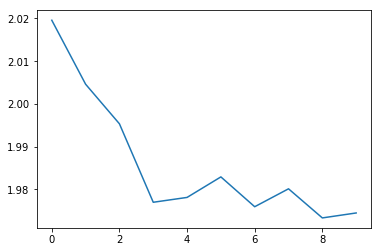

In [12]:
plt.plot(hmc_states["coefs"][:, 0]);

### References

1. `Deep Probabilistic Programming`, [arxiv](https://arxiv.org/abs/1701.03757)<br/>
Dustin Tran, Matthew D. Hoffman, Rif A. Saurous, Eugene Brevdo, Kevin Murphy, David M. Blei

2. `Simple, Distributed, and Accelerated Probabilistic Programming,` [arxiv](https://arxiv.org/abs/1811.02091)<br/>
Dustin Tran, Matthew D. Hoffman, Dave Moore, Christopher Suter, Srinivas Vasudevan, Alexey Radul, Matthew Johnson, Rif A. Saurous